# Simulation Problem 10
## Machine Learning HW3

#### Load Dataset

In [7]:
import pandas as pd
import numpy as np
from os import chdir
from sklearn.model_selection import train_test_split

chdir("/home/kassra/ML/HW_3/data")
df = pd.read_csv("moons.csv", header = None)
data = df.to_numpy()
x_train, x_test, y_train, y_test = train_test_split(data[:,:2], data[:,2], shuffle=True, random_state=1)


Drawing Contours

In [8]:
from scipy.stats import multivariate_normal
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

def plot(x, y, means, covariances):
    class1 = list("")
    class2 = list("")

    for i in range(x.shape[0]):
        if y[i] == 0:
            class1.append(x[i])
        else:
            class2.append(x[i])
    class1 = np.array(class1)
    class2 = np.array(class2)
    plt.plot(class1[:,0], class1[:,1],'.c')
    plt.plot(class2[:,0], class2[:,1],'.y')

    for i in range(means.shape[0]):
        deltaX = (max(x[:,0]) - min(x[:,0]))/10
        deltaY = (max(x[:,1]) - min(x[:,1]))/10
        xmin = min(x[:,0]) - deltaX
        xmax = max(x[:,0]) + deltaX
        ymin = min(x[:,1]) - deltaY
        ymax = max(x[:,1]) + deltaY
        xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]

        target = multivariate_normal(mean=means[i], cov=covariances[i])
        xy = target.rvs()
        xy2 = target.rvs() 
        zz = target.pdf(np.dstack((xx, yy)))
        plt.contour(xx,yy, zz, levels=np.sort([target.pdf(xy), target.pdf(xy2)]))
    plt.title("Actual Data and GMM Contours")
    plt.gcf().set_dpi(100)
    plt.show()

#### Bayesian Estimation (Optimal Bayes with no prior knowledge)

Bayesian Estimation Accuracy:  88.8 %


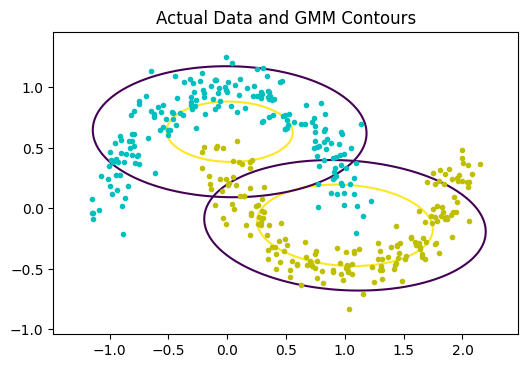

In [9]:
class OptimaBayes:
    def __init__(self, num_feature):
        self.n_class = 2
        self.n_feature = num_feature
        self.dist = None
        pass

    def predict(self, x):
        y = np.empty(x.shape[0])

        for i in range(x.shape[0]):
            if(self.dist[0].pdf(x[i]) > self.dist[1].pdf(x[i])):
                y[i] = 0
            else:
                y[i] = 1               
        return y

    def update(self, x_train, y_train):
        self.dist = list('')
        true = list('')
        false = list('')
        for i in range(x_train.shape[0]):
            if y_train[i] == 1:
                true.append(x_train[i])
            else:
                false.append(x_train[i])
        true = np.array(true)
        false = np.array(false)
        
        mu_true = np.mean(true, axis = 0)
        mu_false = np.mean(false, axis = 0)
        std_true = np.cov(true, rowvar=0)
        std_false = np.cov(false, rowvar=0)

        self.dist.append(multivariate_normal(mu_false, std_false))
        self.dist.append(multivariate_normal(mu_true, std_true))
        
        return mu_true, mu_false, std_true, std_false

ob = OptimaBayes(2)
mu1, mu2, cov1, cov2 = ob.update(x_train, y_train)

mu = np.array([mu1, mu2])
sigma = np.array([cov1, cov2])
print("Bayesian Estimation Accuracy: ",accuracy_score(y_test, ob.predict(x_test)) * 100, "%")
plot(x_train, y_train, mu, sigma)

#### Bayesian Decision making based on GMM

In [10]:
from sklearn.mixture import GaussianMixture

class GMM:
    def __init__(self, n_class, n_feature, k):
        self.n_class = n_class
        self.n_feature = n_feature
        self.k = k
        #self.model = list([GaussianMixture(n_components=k, random_state=1)] * n_class)
        self.model = list("")
        for i in range (self.n_class):
            self.model.append(GaussianMixture(n_components=k, random_state=1))
        pass

    def update(self, x, y):
        samples = list("")
        for i in range(self.n_class):
            samples.append(np.array(x[y == i]))
        aic = 0
        bic = 0
        for i in range(self.n_class):
            self.model[i].fit(samples[i], np.array([i] * samples[i].shape[0]))
            aic += self.model[i].aic(samples[i])
            bic += self.model[i].bic(samples[i])
        return aic, bic

    def predict(self, x):
        likelihood = list("")
        for i in range(self.n_class):
            likelihood.append(self.model[i].score_samples(x))
        likelihood = np.array(likelihood).T
        print(likelihood)
        return np.argmax(likelihood,axis=1)


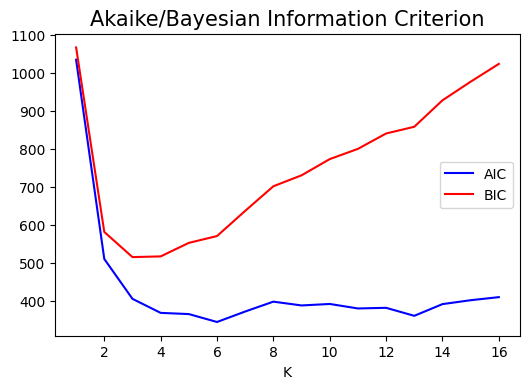

In [20]:
AIC = list([0] * 16)
BIC = list([0] * 16)

classifiers = list("")
for i in range(1,17):
    classifiers.append(GMM(2, 2, i))
    AIC[i-1], BIC[i-1] = classifiers[i-1].update(x_train, y_train)


plt.plot(range(1,17), AIC, 'b', label="AIC")
plt.plot(range(1,17), BIC, 'r', label="BIC")
plt.xlabel("K")
plt.legend()
plt.title("Akaike/Bayesian Information Criterion", fontsize=15)
plt.gcf().set_dpi(100)
plt.show()

#### Visualizing Mixture Contours

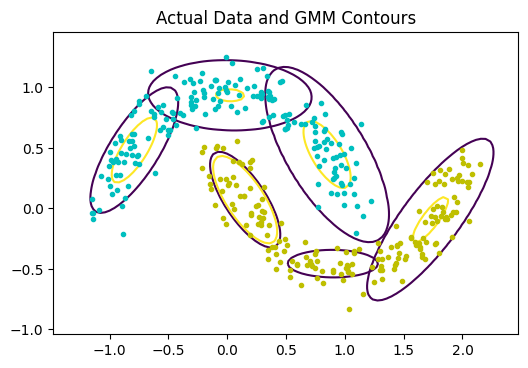

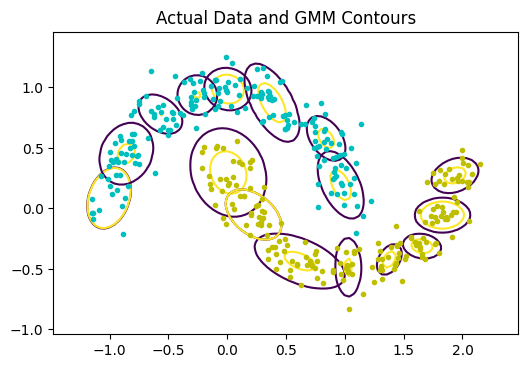

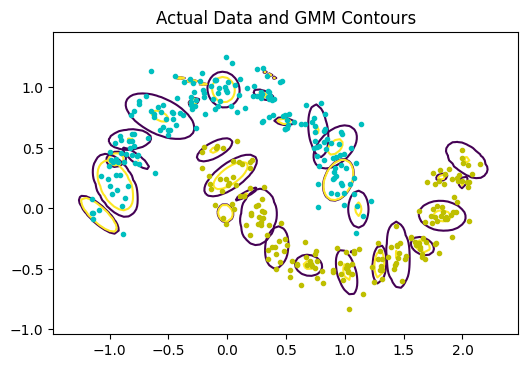

In [31]:
for i in [2, 7, 15]:
    mu = list("")
    cov = list("")
    for j in range(classifiers[i].n_class):
        for k in range(len(classifiers[i].model[j].weights_)):
            mu.append(classifiers[i].model[j].means_[k]) 
            cov.append(classifiers[i].model[j].covariances_[k])
    mu = np.array(mu)
    cov = np.array(cov)   
    plot(x_train, y_train, mu, cov)
